In [58]:
# Preparo las librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Regresión logística
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Decisión entre varios metodos
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# K folds
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier


In [59]:
# Lectura de los datos
pia=pd.read_csv("/train.csv")

# Cambio de tipo de dato de booleano a entero
pia["engagement"] = pia["engagement"].astype(int)

# Cambio de valores de texto a numérico
pia.replace({"True": 1, "False": 0}, inplace = True)

# Quito la columna "id" ya que no la considero una variable
pia.drop("id",axis=1,inplace=True)

# un vistazo a los datos
pia

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.000000,1
1,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.000000,0
2,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.000000,0
3,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.000000,0
4,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.000000,0
...,...,...,...,...,...,...,...,...,...
9234,7,7.820262,14170,82.302473,0.587838,0.027449,2.120000,0.250322,0
9235,6,8.781639,14410,83.361440,0.588235,0.012465,2.251447,0.000000,0
9236,5,7.643789,16240,82.425897,0.611600,0.034213,2.728182,0.000000,0
9237,6,7.985593,14500,87.565381,0.630815,0.020167,2.529861,0.300094,0


Regresión Logística

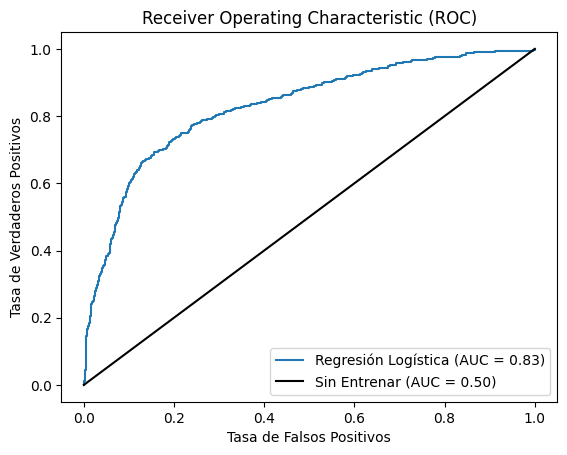

In [72]:
# Generamos un dataset de dos clases
X = pia.iloc[:,:-1]
y = pia.iloc[:,-1]

# Dividimos en training y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=100)

#Generamos un clasificador sin entrenar , que asignará 0 a todo
se_probs = [0 for _ in range(len(ytest))]


# Entrenamos nuestro modelo de reg log
model = LogisticRegression(solver="lbfgs")
model.fit(Xtrain, ytrain)

# Predecimos las probabilidades
lr_probs = model.predict_proba(Xtest)

#Nos quedamos con las probabilidades de la clase positiva (la probabilidad de 1)
lr_probs = lr_probs[:, 1]


# Calculamos el AUC
se_auc = roc_auc_score(ytest, se_probs)
lr_auc = roc_auc_score(ytest, lr_probs)


# Calculamos las curvas ROC
se_fpr, se_tpr, _ = roc_curve(ytest, se_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)

# Curvas ROC
plt.plot(lr_fpr, lr_tpr, label=f'{"Regresión Logística"} (AUC = {lr_auc:.2f})')
plt.plot(se_fpr, se_tpr, color='black', label=f'{"Sin Entrenar"} (AUC = {se_auc:.2f})')

# Etiquetas de los ejes
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend(loc="lower right")
plt.show()

Comparación cruzada entre varios métodos

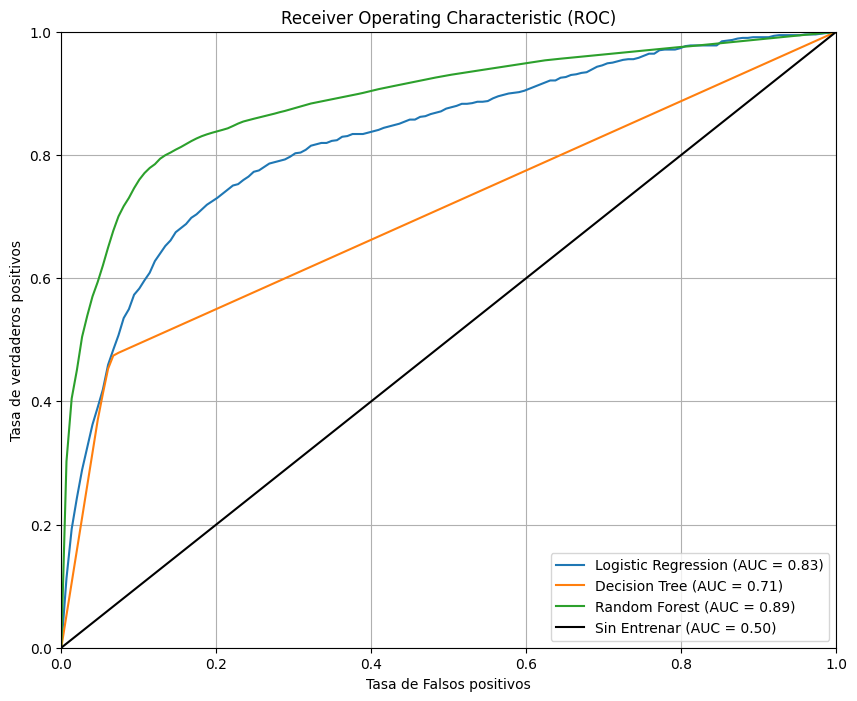

In [71]:
# Separación de los datos, en variable y objetivo
X = pia.iloc[:,:-1]
y = pia.iloc[:,-1]


# Clasificadores a utilizar
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Validación cruzada
valcruz = StratifiedKFold(n_splits=5)
plt.figure(figsize=(10, 8))

#Generamos un clasificador sin entrenar , que asignará 0 a todo
se_probs = [0 for _ in range(len(ytest))]
se_auc = roc_auc_score(ytest, se_probs)
se_fpr, se_tpr, _ = roc_curve(ytest, se_probs)

# Ciclo de clasificadores
for name, clf in classifiers.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 150)

    # Validación cruzada
    for train, test in valcruz.split(X, y):

        # Ajuste del modelo a los datos de entrenamiento
        clf.fit(X.iloc[train], y.iloc[train])

        # Predecir las probabilidades para la clase 1
        y_score = clf.predict_proba(X.iloc[test])[:, 1]

        # Curva ROC
        fpr, tpr, thresholds = roc_curve(y[test], y_score)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolación para encontrar la tasa de verdaderos postivos
        tpr_interpolated = np.interp(mean_fpr, fpr, tpr)
        tpr_interpolated[0] = 0.0
        tprs.append(tpr_interpolated)

    # Cálculo de los promedios
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)
    mean_auc = np.mean(aucs)

    # Curva ROC
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f})')

# Grafica
plt.plot(se_fpr, se_tpr, color='black', label=f'{"Sin Entrenar"} (AUC = {se_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Tasa de Falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Comparación cruzada usando K folds

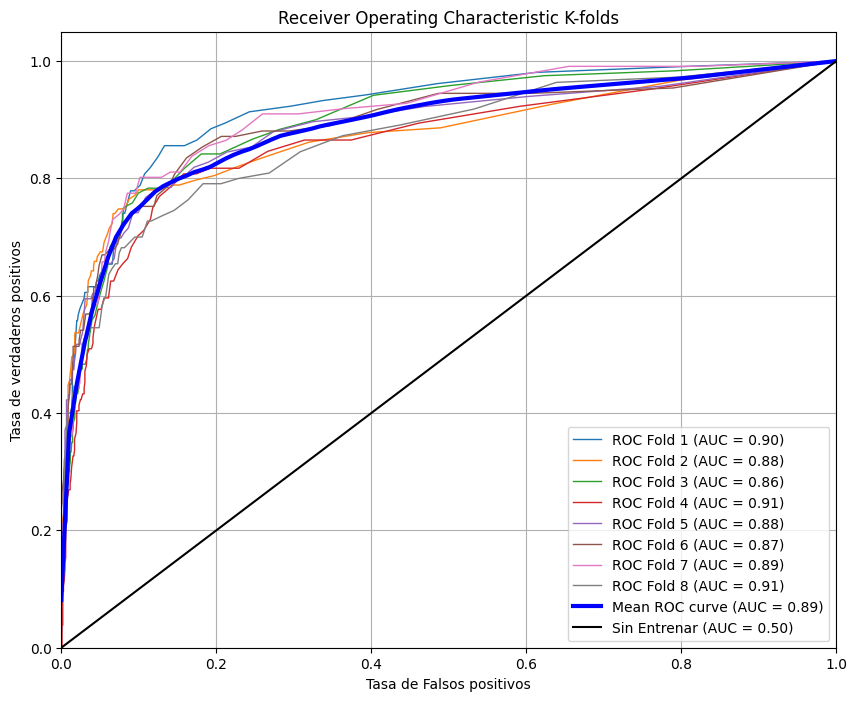

In [75]:
# Generamos un dataset de dos clases
X = pia.iloc[:,:-1]
y = pia.iloc[:,-1]


# clasificador K folds
k = 8  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=50)
classifier = RandomForestClassifier(random_state=50)

# Verdaderos positivos y falsos positivos
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
roc_auc_scores = []
n_fpr = []
n_tpr = []

# Validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ajuste
    classifier.fit(X_train, y_train)

    # Puntuaciones
    y_scores = classifier.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    # Verdaderos y falsos positivos
    n_fpr.append(fpr)
    n_tpr.append(tpr)

    # Interpolación de tasa de verdaderos positivos
    mean_tpr += np.interp(all_fpr, fpr, tpr)

# Promedio de tasa de verdaderos positivos
mean_tpr /= k

# AUC promedio
mean_auc = np.mean(roc_auc_scores)

# Gráfica
plt.figure(figsize=(10, 8))

# Grafica de cada curva
for i, (fpr, tpr) in enumerate(zip(each_fpr, each_tpr)):
    plt.plot(fpr, tpr, lw=1, label=f"ROC Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})")

# Grafica del promedio
plt.plot(all_fpr, mean_tpr, color="blue", label=f"Mean ROC curve (AUC = {mean_auc:.2f})", linewidth=3)

# Línea diagonal
plt.plot([0, 1], [0, 1], color="black",  label=f'{"Sin Entrenar"} (AUC = {se_auc:.2f})')

# Gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Receiver Operating Characteristic K-folds")
plt.legend(loc="lower right")
plt.grid()
plt.show()

